In [2]:
import pandas as pd
from thoughtfulness_features import *
import os
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize

# Create thoughtful comment features

In [ ]:
# Read labelled data
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_labelled.csv'

df = pd.read_csv(file_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# df['Thoughtful?'].sum()

# Creating feature 1 (Structural feature): comment length
comment_length = []
for row in df['Comment']:
    length = get_comment_length(row)
    comment_length.append(length)
df['Length'] = comment_length
df.drop(df[df.Length == 0].index, inplace=True)

length_category = []
for length in df['Length']:
    if length <= 10:
        length_category.append(0)
    elif 11 <= length <= 25:
        length_category.append(1)
    elif 26 <= length <= 50:
        length_category.append(2)
    elif 51 <= length <= 100:
        length_category.append(3)
    else:
        length_category.append(4)
df['Length Category'] = length_category


# Preparation for feature 2 (Lexical feature): comment likelihood
comment_likelihood = []
news_unigram = news_articles_unigram(f'{path_parent}/Data/News Article/articles1.csv')

# Preparation for feature 3 (Syntatic feature): number of verbs
num_verbs = []

# Preparation for feature 4 (Discourse feature): number of discourse relations
num_discourse_relations = []

for row in df['Comment']:
    # Creating feature 2 
    cmt_text_counter = comment_unicounter(row)
    cmt_loglikelihood = news_unigram.evaluate(cmt_text_counter)
    comment_likelihood.append(cmt_loglikelihood)

    # Creating feature 3
    verbs_count = get_num_verbs(row)
    num_verbs.append(verbs_count)

    # Creating feature 4
    discourse_count = num_discourse(row)
    num_discourse_relations.append(discourse_count)

df['Average Loglikelihood'] = comment_likelihood
df['Num Verbs'] = num_verbs
df['Num Discourse Relations'] = num_discourse_relations

# Creating feature 5
    ## Reading in policy texts corpus
corpus = PlaintextCorpusReader(f'{path_parent}/Data/Policy Documents/', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]

    ## Splitting the labelled data to its own policy/topic
circuit_breaker_comments = df[df['Topic'] == 'circuit breaker']
safe_distancing_comments = df[df['Topic'] == 'safe distancing']
tracetogether_comments = df[df['Topic'] == 'Tracetogether']
vaccination_comments = df[df['Topic'] == 'vaccination']
comments = [circuit_breaker_comments, safe_distancing_comments, tracetogether_comments, vaccination_comments]

    ## Calculating KL-divergence relevance score for each comment to its respective policy topic
for i in range(4):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in comments[i]['Comment']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)
# df_final['Relevance score'].min()
# df_final['Relevance score'].max()
df_final.to_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

# Training the classification model

## Perform some basic EDA and standardization of variables

In [342]:
### Basic Imports
import pandas as pd
import numpy as np
from itertools import combinations

### Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 

### Importing the relevant ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score,roc_curve,auc,recall_score,f1_score,precision_score,classification_report,confusion_matrix,auc

In [4]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')
df.head()

,Unnamed: 0,Comment,Label1,Label2,Label3,Thoughtful?,Topic,Length,Length Category,Average Loglikelihood,Num Verbs,Num Discourse Relations,Relevance score
0,0,🇸🇬New Parc Clematis National Day Promo startin...,0,0,0,0,circuit breaker,34,2,-13.944796,4,0,5.691875
1,1,"Oh my fucking God, this announcement could not...",0,0,0,0,circuit breaker,94,3,-11.286315,16,2,3.849035
2,2,Dang it. I was super happy for a while.\n\nIt'...,0,0,0,0,circuit breaker,18,1,-9.626479,3,0,36.848291
3,3,After a beautiful front 9 we got hit with the ...,0,0,0,0,circuit breaker,11,1,-13.549426,2,0,26.305341
4,4,"these people must be tagged, if not cannot ent...",0,0,0,0,circuit breaker,11,1,-11.213937,2,1,55.383696


In [357]:
features_list = ['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
target = 'Thoughtful?'

In [346]:
# Function to plot distribution graphs

def eda_plots(df,features_list,plot_title,fig_size):

    df[features_list].hist(bins=40,edgecolor='b',linewidth=1.0,xlabelsize=8,ylabelsize=8,grid= False,figsize=fig_size ,color='red')

    plt.tight_layout(rect=(0,0,1.2,1.2))

    # Overall title for all the plots
    plt.suptitle(plot_title,x=0.65,y=1.25,fontsize=14)

    plt.show()

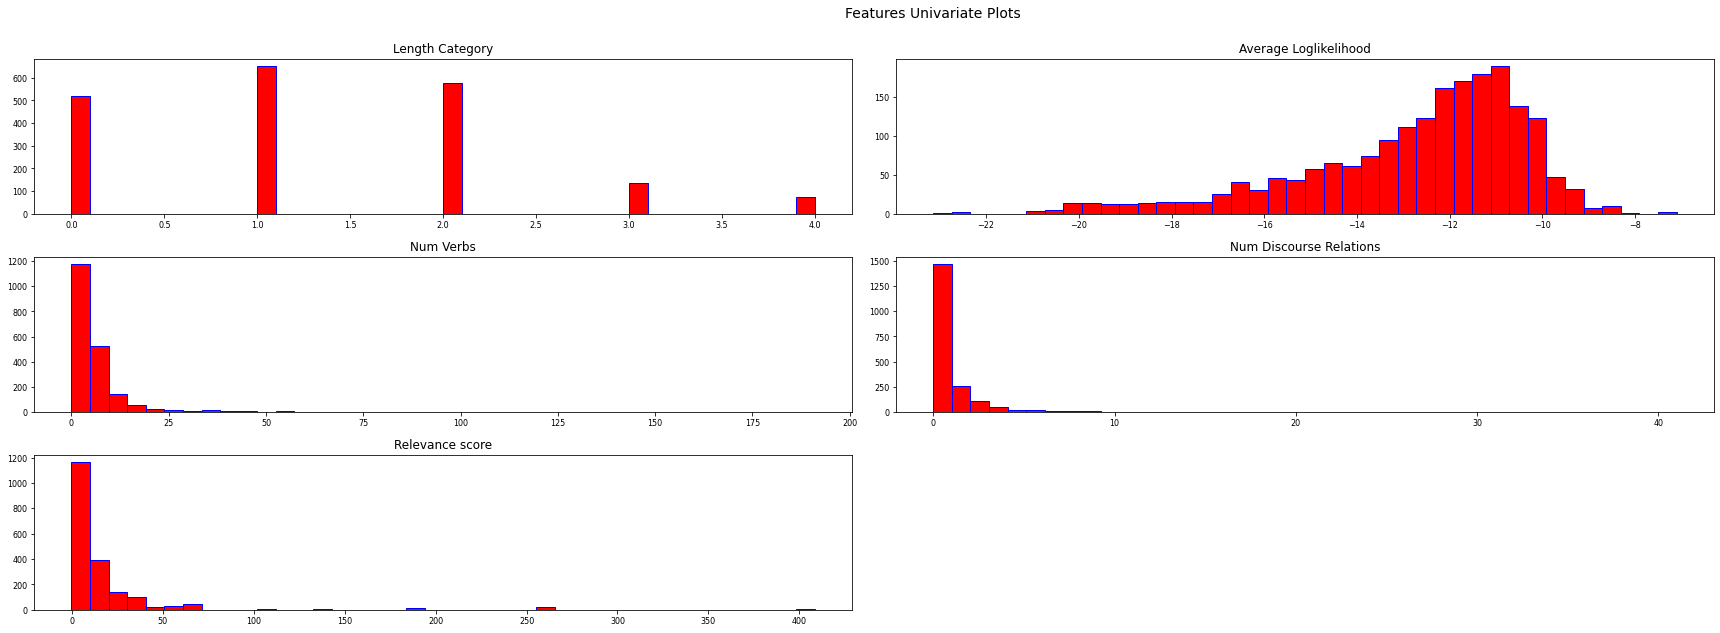

In [347]:
eda_plots(df,features_list,'Features Univariate Plots',(20,7))

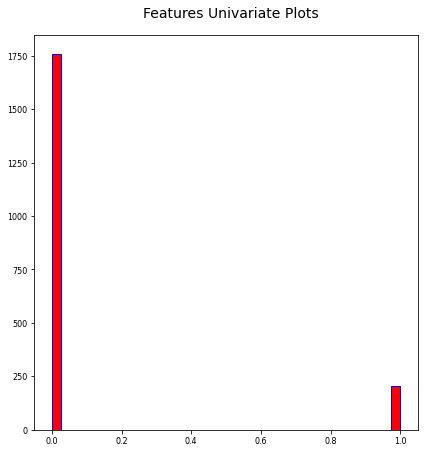

In [348]:
eda_plots(df,target,'Features Univariate Plots',(5,5))

# Standardizing independent variables

In [358]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(df[features_list])
X_scaled = pd.DataFrame(X_scaled, columns=features_list)

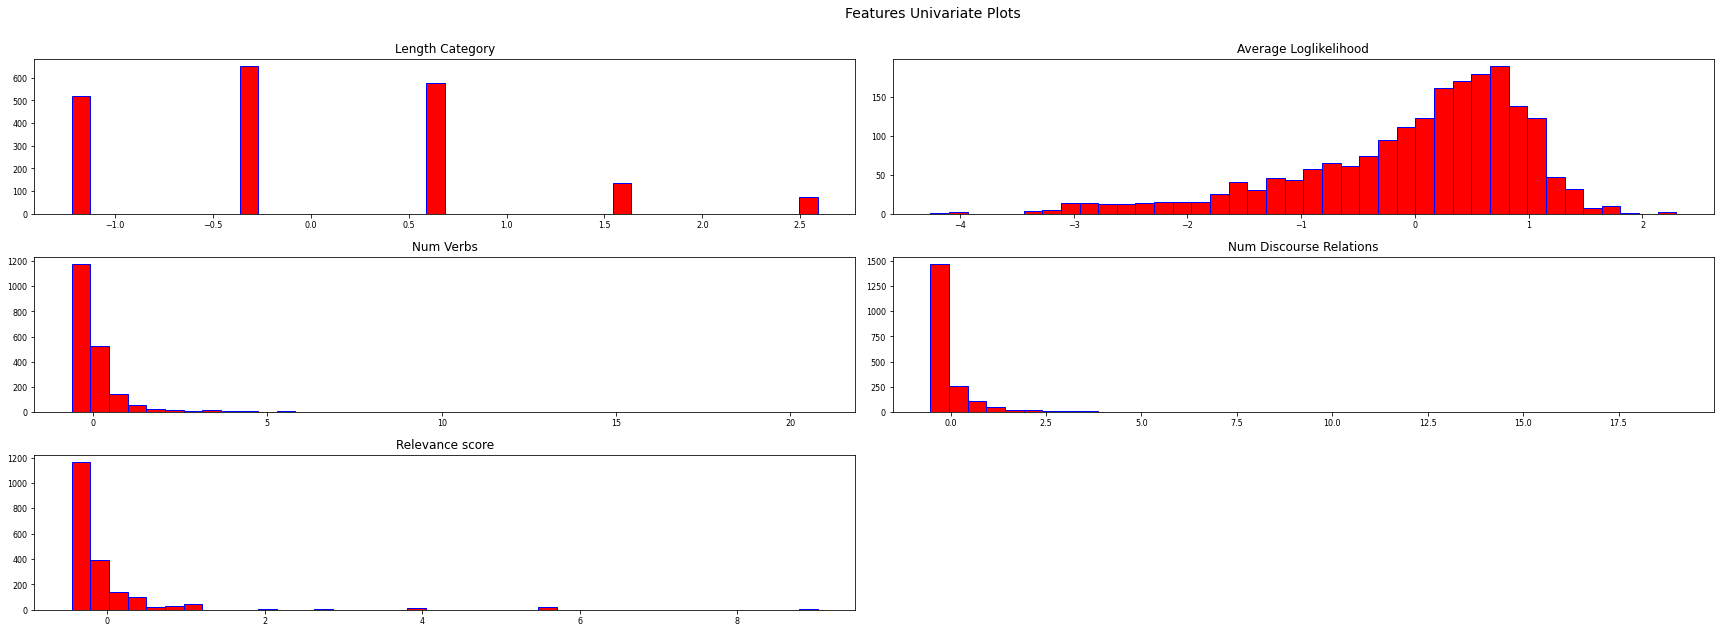

In [350]:
eda_plots(X_scaled,features_list,'Features Univariate Plots',(20,7))

## Actual Modelling (with only training data set)

In [351]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators = 500, random_state=10),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False)
}

In [359]:
# Creating our independent and dependent variables df
X = X_scaled[['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']]
y = df['Thoughtful?']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15) 

# Training with differnent models
for model_name in models_dict:
    m = models_dict[model_name]
    
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    print(model_name)
    print('-'*50)
    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
    print('Precision Score for {} is {:.5f}'.format(model_name,precision))
    print('Recall Score for {} is {:.5f}'.format(model_name,recall))
    print('F1 Score for {} is {:.5f}'.format(model_name,f1))
    print()

Logistic Regression
--------------------------------------------------
Accuracy Score for Logistic Regression is 0.92020
Precision Score for Logistic Regression is 0.75676
Recall Score for Logistic Regression is 0.42424
F1 Score for Logistic Regression is 0.54369

Naive Bayes
--------------------------------------------------
Accuracy Score for Naive Bayes is 0.90832
Precision Score for Naive Bayes is 0.57895
Recall Score for Naive Bayes is 0.66667
F1 Score for Naive Bayes is 0.61972

Decision Trees
--------------------------------------------------
Accuracy Score for Decision Trees is 0.87946
Precision Score for Decision Trees is 0.45614
Recall Score for Decision Trees is 0.39394
F1 Score for Decision Trees is 0.42276

SVM linear
--------------------------------------------------
Accuracy Score for SVM linear is 0.91511
Precision Score for SVM linear is 0.76667
Recall Score for SVM linear is 0.34848
F1 Score for SVM linear is 0.47917

SVM rbf
------------------------------------------

## Stratified K-Fold Sampling due to imbalanced target variable

In [360]:
skf = StratifiedKFold(n_splits=10)
target = df['Thoughtful?']

In [361]:
fold_no = 1
for train_index, test_index in skf.split(df, target):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    print('Fold',str(fold_no),
          'Class Ratio:',
          sum(test['Thoughtful?'])/len(test['Thoughtful?']))
    fold_no += 1

Fold 1 Class Ratio: 0.1065989847715736
Fold 2 Class Ratio: 0.1065989847715736
Fold 3 Class Ratio: 0.10204081632653061
Fold 4 Class Ratio: 0.10204081632653061
Fold 5 Class Ratio: 0.10204081632653061
Fold 6 Class Ratio: 0.10204081632653061
Fold 7 Class Ratio: 0.10204081632653061
Fold 8 Class Ratio: 0.10714285714285714
Fold 9 Class Ratio: 0.10714285714285714
Fold 10 Class Ratio: 0.10714285714285714


In [362]:
skf = StratifiedKFold(n_splits=10)

X = ['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
y = ['Thoughtful?']

model = LogisticRegression()
best_acc = 0
best_train_set = []
best_test_set = []

fold_no = 1
for train_index, test_index in skf.split(df, target):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    
    X_train = train[X]
    y_train = train[y]
    X_test = test[X]
    y_test = test[y]
    model.fit(X_train, y_train.values.ravel())
    predictions = model.predict(X_test)
    if accuracy_score(y_test,predictions) > best_acc:
        best_acc = accuracy_score(y_test,predictions)
        best_train_set = train
        best_test_set = test
    print('Fold', str(fold_no), 'Accuracy:', accuracy_score(y_test,predictions))

    fold_no += 1

Fold 1 Accuracy: 0.9035532994923858
Fold 2 Accuracy: 0.883248730964467
Fold 3 Accuracy: 0.923469387755102
Fold 4 Accuracy: 0.9540816326530612
Fold 5 Accuracy: 0.9387755102040817
Fold 6 Accuracy: 0.9591836734693877
Fold 7 Accuracy: 0.8928571428571429
Fold 8 Accuracy: 0.8928571428571429
Fold 9 Accuracy: 0.8979591836734694
Fold 10 Accuracy: 0.9387755102040817


## Cross Validation after Stratified K-Fold Sampling

In [364]:
X = df[['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']]
y = df[['Thoughtful?']]

In [365]:
for model_name in models_dict:
    m = models_dict[model_name]
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(m, X.values, y.values.ravel(), scoring=scoring, cv=10)

    print(model_name)
    print('-'*50)
    print(f"Mean accuracy is {scores['test_accuracy'].mean()}")
    print(f"Mean precision is {scores['test_precision'].mean()}")
    print(f"Mean recall is {scores['test_recall'].mean()}")
    print(f"Mean f1 is {scores['test_f1'].mean()}")
    print()
    print()

Logistic Regression
--------------------------------------------------
Mean accuracy is 0.9184761214130323
Mean precision is 0.6744122544122544
Mean recall is 0.42738095238095236
Mean f1 is 0.5077242346292766


Naive Bayes
--------------------------------------------------
Mean accuracy is 0.9082487309644671
Mean precision is 0.5602568645747057
Mean recall is 0.6854761904761906
Mean f1 is 0.6096922356877655


Decision Trees
--------------------------------------------------
Mean accuracy is 0.8914378949549363
Mean precision is 0.49306219143175667
Mean recall is 0.5128571428571428
Mean f1 is 0.49503628245556597


SVM linear
--------------------------------------------------
Mean accuracy is 0.915925101004869
Mean precision is 0.7442460317460318
Mean recall is 0.32452380952380955
Mean f1 is 0.43292941509891864


SVM rbf
--------------------------------------------------
Mean accuracy is 0.9087744742567077
Mean precision is 0.8166666666666667
Mean recall is 0.1766666666666667
Mean f1 is 0

### From the cross validation, with 10 stratified k-folds, naives bayes classifier seems to be the best one based on highest recall score and f1 score.

# Perform Random Forest Feature Selection to look at importance of each features

In [366]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [377]:
df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

X = df[['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']]
y = df['Thoughtful?']
feat_labels = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [378]:
sel_rfc = SelectFromModel(RandomForestClassifier(n_estimators = 500, random_state=10))
sel_rfc.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=500))

In [380]:
selected_feat= X_train.columns[(sel_rfc.get_support())]
selected_feat

Index(['Average Loglikelihood', 'Num Verbs', 'Relevance score'], dtype='object')

In [13]:
clf = RandomForestClassifier(n_estimators=500, random_state=10)
clf.fit(X_train, y_train)

for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

('Length', 0.17867493697192824)
('Average Loglikelihood', 0.24205135288333382)
('Num Verbs', 0.22706373798186363)
('Num Discourse Relations', 0.1228914517745591)
('Relevance score', 0.2293185203883152)


# Testing against validation data

## Preparing validation data thoughtful comments features

In [386]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = f'{path_parent}/Data/Thoughtful Comments/validation_comments.xls'

In [387]:
validation_df = pd.read_excel(file_path)
validation_df.head()

## Creating features for validation data

In [389]:
# Creating feature 1
comment_length = []
for row in validation_df['Comment']:
    length = get_comment_length(row)
    comment_length.append(length)
validation_df['Length'] = comment_length

# Removing rows with zero comment length before creating features 2 to 5
validation_df.drop(validation_df[validation_df.Length == 0].index, inplace=True)

length_category = []
for length in validation_df['Length']:
    if length <= 10:
        length_category.append(0)
    elif 11 <= length <= 25:
        length_category.append(1)
    elif 26 <= length <= 50:
        length_category.append(2)
    elif 51 <= length <= 100:
        length_category.append(3)
    else:
        length_category.append(4)
validation_df['Length Category'] = length_category


# Preparation for feature 2 (Lexical feature): comment likelihood
comment_likelihood = []
# news_unigram = news_articles_unigram(f'{path_parent}/Data/News Article/articles1.csv')

# Preparation for feature 3 (Syntatic feature): number of verbs
num_verbs = []

# Preparation for feature 4 (Discourse feature): number of discourse relations
num_discourse_relations = []

for row in validation_df['Comment']:
    # Creating feature 2 
    cmt_text_counter = comment_unicounter(row)
    cmt_loglikelihood = news_unigram.evaluate(cmt_text_counter)
    comment_likelihood.append(cmt_loglikelihood)

    # Creating feature 3
    verbs_count = get_num_verbs(row)
    num_verbs.append(verbs_count)

    # Creating feature 4
    discourse_count = num_discourse(row)
    num_discourse_relations.append(discourse_count)

validation_df['Average Loglikelihood'] = comment_likelihood
validation_df['Num Verbs'] = num_verbs
validation_df['Num Discourse Relations'] = num_discourse_relations

# Creating feature 5
corpus = PlaintextCorpusReader(f'{path_parent}/Data/Policy Documents/', '.+\.txt', encoding='utf-8')
fid = corpus.fileids()
fid.sort()

doc_words = [corpus.words(f) for f in fid]
doc_words = [doc_words[0], doc_words[3]]

circuit_breaker_comments = validation_df[validation_df['Topic'] == 'Circuit Breaker']
vaccination_comments = validation_df[validation_df['Topic'] == 'Vaccination']
comments = [circuit_breaker_comments, vaccination_comments]

for i in range(2):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in comments[i]['Comment']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

df_final = pd.concat(comments, ignore_index=True)

# df_final['Relevance score'].max()
# df_final['Relevance score'].min()

df_final.to_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_final.csv')

## Testing trained model against validation data

In [406]:
training_data = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')
validation_data = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_final.csv')

In [458]:
# Creating our independent and dependent variables df
X = ['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
y = ['Thoughtful?']

# Training with differnent models
for model_name in models_dict:
    m = models_dict[model_name]

    X_train = training_data[X]
    y_train = training_data[y]
    X_test = validation_data[X]
    y_test = validation_data[y]
    
    m.fit(X_train, y_train.values.ravel())
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    print(model_name)
    print('-'*50)
    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
    print('Precision Score for {} is {:.5f}'.format(model_name,precision))
    print('Recall Score for {} is {:.5f}'.format(model_name,recall))
    print('F1 Score for {} is {:.5f}'.format(model_name,f1))
    print()

Logistic Regression
--------------------------------------------------
Accuracy Score for Logistic Regression is 0.92411
Precision Score for Logistic Regression is 0.62500
Recall Score for Logistic Regression is 0.29412
F1 Score for Logistic Regression is 0.40000

Naive Bayes
--------------------------------------------------
Accuracy Score for Naive Bayes is 0.93423
Precision Score for Naive Bayes is 0.60345
Recall Score for Naive Bayes is 0.68627
F1 Score for Naive Bayes is 0.64220

Decision Trees
--------------------------------------------------
Accuracy Score for Decision Trees is 0.91737
Precision Score for Decision Trees is 0.52273
Recall Score for Decision Trees is 0.45098
F1 Score for Decision Trees is 0.48421

SVM linear
--------------------------------------------------
Accuracy Score for SVM linear is 0.92411
Precision Score for SVM linear is 0.68750
Recall Score for SVM linear is 0.21569
F1 Score for SVM linear is 0.32836

SVM rbf
------------------------------------------

## ROC Curve

In [460]:
prob_no_unsampled = model.predict_proba(X_test)
prob_no_unsampled = [p[1] for p in prob_no_unsampled]
print(roc_auc_score(y_test, prob_no_unsampled))

0.9138991389913899


In [461]:
validation_data['Prediction_no_upsampling'] = predictions

### Number of comments correctly predicted as thoughtful

In [462]:
predicted_true_positive = len(validation_data[(validation_data['Prediction_no_upsampling'] == 1) & (validation_data['Thoughtful?'] == 1)])
actual_true_positive = validation_data['Thoughtful?'].sum()

print(f'Number of comments correctly predicted as thoughtful = {predicted_true_positive}')
print(f'Number of actual comments labelled as thoughtful = {actual_true_positive}')

# validation_data.to_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_prediction.csv')

35

# Remodelling with Upsampling method, testing with training data alone + against validation data

In [419]:
from sklearn.utils import resample

In [463]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))

df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

df_thoughtful = df[df['Thoughtful?'] == 1]
df_unthoughtful = df[df['Thoughtful?'] == 0]

print(len(df_thoughtful))
print(len(df_unthoughtful))

In [465]:
df_thoughtful_upsampled = resample(df_thoughtful, replace=True, n_samples=1000, random_state=170)
df_upsampled = pd.concat([df_unthoughtful, df_thoughtful_upsampled])

In [466]:
def get_features_combi(features, n):
    comb = []
    for i in range(2, n+1):
        temp = list(combinations(features, i))
        comb += temp
    return comb

comb = get_features_combi(['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score'], 5)

In [467]:
scores = {
    'best_combi': None, 
    'acc': 0, 
    'prec': 0,
    'rec': 0,
    'f1': 0
}
for features in comb:
    # Creating our independent and dependent variables df
    X = df_upsampled[list(features)]
    y = df_upsampled['Thoughtful?']

    # Perform train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15) 

    # Training with differnent models
    for model_name in models_dict:
        m = models_dict[model_name]
        
        m.fit(X_train, y_train)
        predictions = m.predict(X_test)

        acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels
        precision = precision_score(y_test,predictions) 
        recall = recall_score(y_test,predictions) 
        f1 = f1_score(y_test,predictions)

        if f1 > scores['f1']:
            scores['best_combi'] = features
            scores['f1'] = f1
        # scores[features].append((model_name, acc, precision, recall, f1))
        # print(model_name)
        # print('-'*50)
        # print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
        # print('Precision Score for {} is {:.5f}'.format(model_name,precision))
        # print('Recall Score for {} is {:.5f}'.format(model_name,recall))
        # print('F1 Score for {} is {:.5f}'.format(model_name,f1))
        # print()
scores

[16:38:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

{'best_combi': ('Length Category',
  'Average Loglikelihood',
  'Num Verbs',
  'Relevance score'),
 'acc': 0,
 'prec': 0,
 'rec': 0,
 'f1': 0.9468599033816424}

## Testing against validation data

In [468]:
df_validation = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_final.csv')

In [469]:
scores = {
    'features': [],
    'model': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}
for features in comb:
    # Creating our independent and dependent variables df
    X = list(features)
    y = ['Thoughtful?']

    # Training with differnent models
    for model_name in models_dict:
        m = models_dict[model_name]

        X_train = df_upsampled[X]
        y_train = df_upsampled[y]
        X_test = df_validation[X]
        y_test = df_validation[y]
        
        m.fit(X_train, y_train.values.ravel())
        predictions = m.predict(X_test)

        acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
        precision = precision_score(y_test,predictions) 
        recall = recall_score(y_test,predictions) 
        f1 = f1_score(y_test,predictions)

        
        scores['features'].append(features)
        scores['model'].append(model_name)
        scores['accuracy'].append(acc)
        scores['precision'].append(precision)
        scores['recall'].append(recall)
        scores['f1'].append(f1)

        # print(model_name)
        # print('-'*50)
        # print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
        # print('Precision Score for {} is {:.5f}'.format(model_name,precision))
        # print('Recall Score for {} is {:.5f}'.format(model_name,recall))
        # print('F1 Score for {} is {:.5f}'.format(model_name,f1))
        # print()

scores_df = pd.DataFrame(scores)
# scores_df.to_csv('/Users/chenjianyu/Desktop/scores2.csv')

[16:40:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [473]:
X = ['Length Category', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
y = ['Thoughtful?']

X_train = df_upsampled[X]
y_train = df_upsampled[y]
X_test = df_validation[X]
y_test = df_validation[y]
# model1 = GaussianNB().fit(X_train, y_train.values.ravel())
model1 = svm.SVC(kernel='rbf').fit(X_train, y_train.values.ravel())
predictions = model1.predict(X_test)

acc = accuracy_score(y_test,predictions)  
precision = precision_score(y_test,predictions) 
recall = recall_score(y_test,predictions) 
f1 = f1_score(y_test,predictions)

print('Accuracy Score is {:.5f}'.format(acc))
print('Precision Score is {:.5f}'.format(precision))
print('Recall Score is {:.5f}'.format(recall))
print('F1 Score is {:.5f}'.format(f1))

Accuracy Score is 0.93929
Precision Score is 0.62295
Recall Score is 0.74510
F1 Score is 0.67857


acc, pred, rec, f1 score from model without upsampling: 
<br>Accuracy Score is 0.91737
<br>Precision Score is 0.60465
<br>Recall Score is 0.44828
<br>F1 Score is 0.51485
<br>ROC score is 0.8870125684821141

## ROC Score

In [452]:
prob_upsampled = model1.predict_proba(X_test)
prob_upsampled = [p[1] for p in prob_upsampled]
print(roc_auc_score(y_test, prob_upsampled))

0.9306851892048331


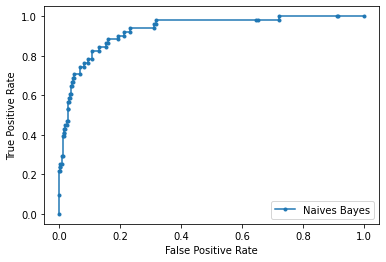

In [453]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, prob_upsampled)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Naives Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [454]:
validation_data['Prediction_upsampling'] = predictions
validation_data.to_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_prediction.csv')

len(validation_data[(validation_data['Prediction_upsampling'] == 1) & (validation_data['Thoughtful?'] == 1)])